In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

In [5]:
digits = datasets.load_digits()

In [25]:
# courtesy caffe devs
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data, cmap = plt.get_cmap('gray') )


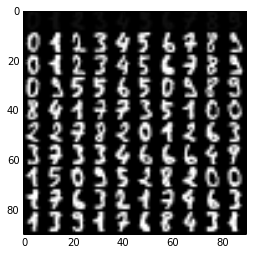

In [27]:
vis_square( digits.data[ 0:100 ].reshape(100,8,8) )


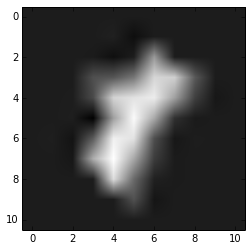

In [31]:
from scipy.ndimage.interpolation import rotate

i2 = rotate( input=digits.data[ 1 ].reshape( 8, 8 ), angle=-30. )

plt.imshow( i2, cmap = plt.get_cmap('gray') )


In [30]:
%timeit rotate( input=digits.data[ 1 ].reshape( 8, 8 ), angle=30. )

The slowest run took 6.92 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 99.5 µs per loop


In [34]:
from sklearn.cross_validation import train_test_split
# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( digits.data, 
                                                    digits.target,
                                                    test_size=0.33 )

In [74]:
import lmdb
import sys
sys.path.append( '/localhome/marcino/work/caffe/python' )
import caffe

env = lmdb.open( 'digits_train_lmdb', map_size=1000000000L )

NUM_OF_ROTATIONS = 16

rotations = np.random.uniform( low= -30., high=30., size=( X_train.shape[0], NUM_OF_ROTATIONS ) )

k = 0
for i in range( X_train.shape[0] ):
    x_in = X_train[ i ].reshape( (8,8) )
    
    # add original digit
    datum = caffe.proto.caffe_pb2.Datum()
    datum.channels = 1
    datum.height = 8
    datum.width = 8
    datum.data = x_in.tostring()
    datum.label = int( y_train[i] )

    str_id = '{:08}'.format( k )
    k += 1
    with env.begin( write=True ) as txn:
        txn.put( str_id.encode('ascii'), datum.SerializeToString() )
    
    # add rotations
    for j in range( rotations.shape[ 1 ] ):
        rotated_x = rotate( input=x_in, angle=rotations[ i, j ] )
        datum = caffe.proto.caffe_pb2.Datum()
        datum.channels = 1
        datum.height = 8
        datum.width = 8
        datum.data = rotated_x.tostring()
        datum.label = int( y_train[i] )

        str_id = '{:08}'.format( k )
        k += 1
        with env.begin( write=True ) as txn:
            txn.put( str_id.encode('ascii'), datum.SerializeToString() )

print( env.stat() )
env.close()

env = lmdb.open( 'digits_test_lmdb', map_size=1000000000L )
k = 0
for i in range( X_test.shape[0] ):
    # add original digit
    datum = caffe.proto.caffe_pb2.Datum()
    datum.channels = 1
    datum.height = 8
    datum.width = 8
    datum.data = X_test[ i ].tostring()
    datum.label = int( y_test[i] )
    
    str_id = '{:08}'.format( k )
    k += 1
    with env.begin( write=True ) as txn:
        txn.put( str_id.encode('ascii'), datum.SerializeToString() )

print( env.stat() )
env.close()


{'branch_pages': 26L, 'leaf_pages': 5451L, 'overflow_pages': 0L, 'psize': 4096L, 'depth': 3L, 'entries': 20451L}
{'branch_pages': 1L, 'leaf_pages': 99L, 'overflow_pages': 0L, 'psize': 4096L, 'depth': 2L, 'entries': 594L}


In [75]:
solver_txt = """
# The train/test net protocol buffer definition
net: "digits_train_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# the batch is 100 images, covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "digits"
# solver mode: CPU or GPU
solver_mode: GPU

"""

open( 'digits_solver.prototxt', 'wt' ).write( solver_txt )

digits_train_test = """
name: "digits"
layer {
  name: "digits_data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.0625
  }
  data_param {
    source: "digits_train_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "digits_data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    scale: 0.0625
  }
  data_param {
    source: "digits_test_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  convolution_param {
    num_output: 20
    kernel_size: 3
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  convolution_param {
    num_output: 50
    kernel_size: 3
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 500
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "ip1"
  top: "ip1"
}
layer {
  name: "ip2"
  type: "InnerProduct"
  bottom: "ip1"
  top: "ip2"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 10
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "ip2"
  bottom: "label"
  top: "accuracy"
  include {
    phase: TEST
  }
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "ip2"
  bottom: "label"
  top: "loss"
}
"""

open( 'digits_train_test.prototxt', 'wt' ).write( digits_train_test )

In [76]:
!./caffe/build/tools/caffe train -solver digits_solver.prototxt

I0811 20:54:40.812274 29555 caffe.cpp:113] Use GPU with device ID 0
I0811 20:54:41.175806 29555 caffe.cpp:121] Starting Optimization
I0811 20:54:41.175945 29555 solver.cpp:32] Initializing solver from parameters: 
test_iter: 100
test_interval: 500
base_lr: 0.01
display: 100
max_iter: 10000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
snapshot: 5000
snapshot_prefix: "digits"
solver_mode: GPU
net: "digits_train_test.prototxt"
I0811 20:54:41.176013 29555 solver.cpp:70] Creating training net from net file: digits_train_test.prototxt
I0811 20:54:41.176491 29555 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer digits_data
I0811 20:54:41.176518 29555 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0811 20:54:41.176619 29555 net.cpp:42] Initializing net from parameters: 
name: "digits"
state {
  phase: TRAIN
}
layer {
  name: "digits_data"
  type: "Data"
  top: "d

In [88]:
!./caffe/build/tools/caffe test  -model digits_iter_10000.caffemodel -weights digits_iter_10000.solverstate

I0811 20:59:02.457888  9346 caffe.cpp:151] Use CPU.
[libprotobuf ERROR google/protobuf/text_format.cc:245] Error parsing text-format caffe.NetParameter: 2:1: Invalid control characters encountered in text.
[libprotobuf ERROR google/protobuf/text_format.cc:245] Error parsing text-format caffe.NetParameter: 2:8: Message type "caffe.NetParameter" has no field named "digits".
F0811 20:59:02.797425  9346 upgrade_proto.cpp:928] Check failed: ReadProtoFromTextFile(param_file, param) Failed to parse NetParameter file: digits_iter_10000.caffemodel
*** Check failure stack trace: ***
    @     0x7fef2871fdaa  (unknown)
    @     0x7fef2871fce4  (unknown)
    @     0x7fef2871f6e6  (unknown)
    @     0x7fef28722687  (unknown)
    @     0x7fef28a68c3e  caffe::ReadNetParamsFromTextFileOrDie()
    @     0x7fef28a95ec0  caffe::Net<>::Net()
    @           0x40529f  test()
    @           0x404a21  main
    @     0x7fef27c31ec5  (unknown)
    @           0x404fcd  (unknown)
    @              (nil)  (u

In [83]:
!./caffe/build/tools/caffe

caffe: command line brew
usage: caffe <command> <args>

commands:
  train           train or finetune a model
  test            score a model
  device_query    show GPU diagnostic information
  time            benchmark model execution time

  Flags from tools/caffe.cpp:
    -gpu (Run in GPU mode on given device ID.) type: int32 default: -1
    -iterations (The number of iterations to run.) type: int32 default: 50
    -model (The model definition protocol buffer text file..) type: string
      default: ""
    -snapshot (Optional; the snapshot solver state to resume training.)
      type: string default: ""
    -solver (The solver definition protocol buffer text file.) type: string
      default: ""
    -weights (Optional; the pretrained weights to initialize finetuning. Cannot
      be set simultaneously with snapshot.) type: string default: ""


In [87]:
ls -l

total 1618120
-rw-rw-r--  1 marcino marcino     977224 Aug 11 14:47 00-classification.ipynb
-rw-rw-r--  1 marcino marcino    1120495 Aug 10 21:58 00-classification.ipynb.1
-rw-rw-r--  1 marcino marcino    1120495 Aug 10 21:58 00-classification.ipynb.2
-rw-rw-r--  1 marcino marcino    1120495 Aug 10 21:59 00-classification.ipynb.3
-rw-rw-r--  1 marcino marcino  154190693 Jul 15 22:25 2015-07-15-22-23-34.bag
drwxrwxr-x  2 marcino marcino       4096 Jun 14 11:43 3d/
-rw-rw-r--  1 marcino marcino     194334 Aug 10 21:17 Classification_Ensemble.html
-rw-rw-r--  1 marcino marcino       9403 Aug 10 21:29 Classification_Ensemble.ipynb
-rw-rw-r--  1 marcino marcino     163317 Aug 11 20:58 Classification_With_NN.ipynb
drwxrwxr-x 12 marcino marcino       4096 Dec 26  2014 NVIDIA_CUDA-6.5_Samples/
drwxrwxr-x  9 marcino marcino       4096 Jun 14 10:13 Printrun/
drwxr-xr-x  6 marcino marcino       4096 Aug  4  2014 Slic3r/
-rw-rw-r--  1 marcino marcino      74293 Aug 10 22:17 Untitled.ipynb
-rw-rw-r

In [57]:
1/16.

0.0625